In [1]:
# First load in video frames
import numpy as np
import matplotlib.pyplot as plt
import cv2
import reconstruction
from skimage.transform import resize
import transformations


Using TensorFlow backend.


In [2]:
# Load image and mask
preload=True
if preload:
    images = np.load(open("./data/storm_frames.npy", "rb"))
    mask = np.load(open("./data/mask_thresh.npy", "rb"))
else: 
#     images = 
    pass

In [3]:
# convert images to gray
s1, s2 = images[0].shape[0]//2, images[0].shape[1]//2

gray_images = np.zeros((images.shape[0], s1, s2)).astype(np.uint8)
print(gray_images.shape)
for i in range(images.shape[0]):
    gray256 = np.array(cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)).astype(np.uint8)
    gray_images[i] = resize(gray256, (s1, s2), preserve_range=True)


(53, 128, 128)


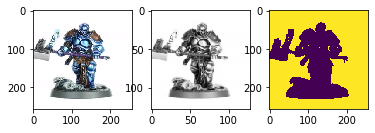

In [4]:
fig, ax = plt.subplots(1,3)
idx = 16

ax[0].imshow(images[idx])
ax[1].imshow(gray_images[idx], cmap="Greys_r")
ax[2].imshow(mask[idx])
plt.show()

In [5]:
# depths module needs pictures to be 640x480
padded_images = np.full((images.shape[0], 640, 480, 3), 255)
for i in range(images.shape[0]):
    padded_images[i, 
                  320-images[i].shape[0]//2: 320 + images[i].shape[0]//2,
                  240-images[i].shape[1]//2: 240 + images[i].shape[1]//2, :] = images[i]

depths = reconstruction.depth_estimation(padded_images)

Loading model...
Model loaded (nyu.h5).
Running model...
Done.


In [6]:
images.shape

(53, 256, 256, 3)

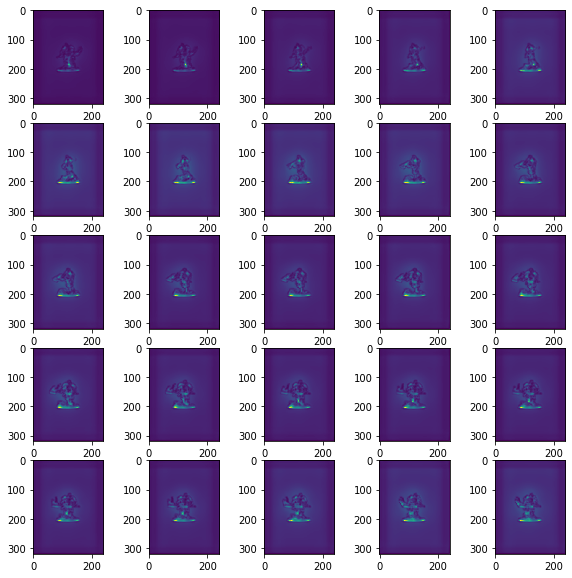

In [7]:
%matplotlib inline
fig, ax = plt.subplots(5,5, figsize=(10,10))
count=0
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(depths[count, :, :, 0])
        count+=1
plt.show()

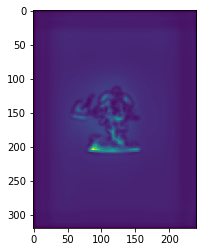

In [8]:
plt.imshow(depths[idx,:,:,0])

plt.show()

In [9]:

depths_trunc = depths[1:-2]

small_size = images.shape[1] // 2, images.shape[2] // 2

unpadded_depths = np.zeros((depths_trunc.shape[0], small_size[0], small_size[1]))

depth_masks = np.full((unpadded_depths.shape[0], small_size[0], small_size[1]), False)
print(unpadded_depths.shape[0])
for i in range(unpadded_depths.shape[0]):
    downsamp_mask = resize(mask[i], (small_size[0], small_size[1]))
    depth_masks[i] = downsamp_mask > 0
    unpadded_depths[i] = depths_trunc[i, 
                                160-images[i].shape[0]//4: 160 + images[i].shape[0]//4,
                                120-images[i].shape[1]//4: 120 + images[i].shape[1]//4, 0]
#     print(unpadded_depths[i], unpadded_depths[i].shape)
#     print(downsamp_mask, downsamp_mask.shape)
#     print(unpadded_depths[i][downsamp_mask])
    unpadded_depths[i][depth_masks[i]] = 0

50


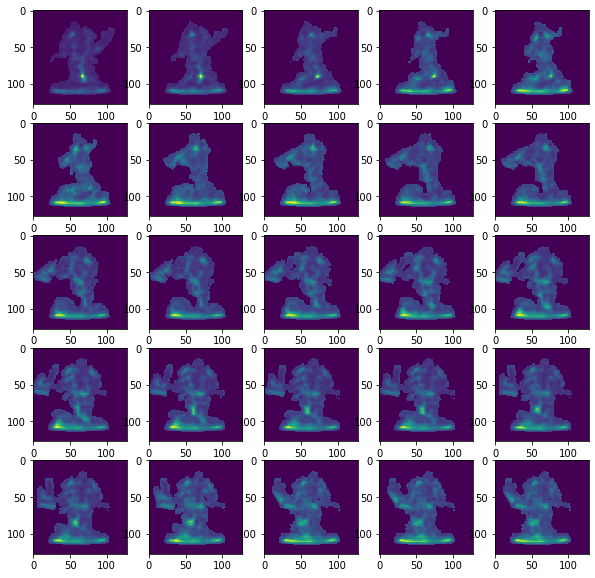

In [10]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
count=0
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(unpadded_depths[count, :, :])
        count+=1
plt.show()

In [11]:
tfs = transformations.transforms(gray_images[1:-2], mask)

In [23]:
# Now putting all points in the same frame
from utils import convert_to_base_frame

point_clouds = []
for i in range(unpadded_depths.shape[0]):
    points = np.nonzero(unpadded_depths[i])
    p_array = np.array([points[0][0], points[1][0], unpadded_depths[i][points[0][0], points[0][1]]])
    for j in range(1, points[0].shape[0]):
        p_array = np.vstack((p_array, np.array([points[0][j], points[1][j], unpadded_depths[i][points[0][j], points[0][j]]])))
    print(i, tfs.shape[0])
    p_array_transform = convert_to_base_frame(p_array, tfs, i, tfs.shape[0])
    point_clouds.append(p_array_transform[0])

0 49
1 49
2 49
3 49
4 49
5 49
6 49
7 49
8 49
9 49
10 49
11 49
12 49
13 49
14 49
15 49
16 49
17 49
18 49
19 49
20 49
21 49
22 49
23 49
24 49
25 49
26 49
27 49
28 49
29 49
30 49
31 49
32 49
33 49
34 49
35 49
36 49
37 49
38 49
39 49
40 49
41 49
42 49
43 49
44 49
45 49
46 49
47 49
48 49
49 49


In [35]:
point_clouds_total = point_clouds[0]
for i in range(1, len(point_clouds)):
    point_cloud_total = np.vstack((point_clouds_total, point_clouds[i]))

In [37]:
reconstruction.pt_cloud_to_file(point_clouds_total, "./data/output.stl")

Downsample the point cloud with a voxel of 0.05
computing mesh
simplifying mesh
simplifying more
saving mesh
